# Absolute Receiver Calibration on an Arbitrary Frequency Grid Using an Arbitrary Waveform Generator

## Goal: 
Calibrate the receiver of a VNA in both amplitude and absolute phase on an arbitrary frequency grid, with special attention to frequency spacings less than 625 KHz (smallest attainable using a frequency comb). 

## Procedure:
Procedure for a single port.
$$A1_{Calibrated} = C_{A1}*A1_{raw}$$

$$A1_{raw} = |A1_{Reading}|*e^{-i*(\phi_{reading}-\phi_{measurement phase reference})}$$

### 1. Scattering Parameter Calibration
1. Measure S11 of each of the following, short, open and load, on the frequency grid of interest.
2. Measure S11 of the oscilloscope and power meter to be used in the calibration
3. Calculate the 2-port error adapter for the port,$\begin{pmatrix} EA_{11} & EA_{12}\\ EA_{21} & EA_{22} \end{pmatrix}$ and correct S11 of the oscilloscope and power meter.$\Gamma_{scope},\Gamma_{pm}$

### 2. Power Calibration
1. Measure the out going wave on port of interest (A1) at the same time as power meter reading for the frequencies of interest.
$|C_{A1}| = |{ \frac{ \sqrt{2*Power Meter Reading*50*\frac{1+\Gamma_{pm}}{1-\Gamma_{pm}}}*(1-\Gamma_{pm}*EA_{22})}{A1_{raw}*EA_{21}}}|$

### 3. Phase Calibration
1. Establish a phase stable master clock, in this case we use a PSG creating a 10 GHz sine wave
2. Use the AWG to create a multisine with components at all frequencies of interest (if this exceeds the sampling rate of the AWG (1/Clock Frequency) then a mixer step is required). Place a marker in the file to trigger the oscilloscope. This signal is now connected to at least one receiver in the VNA as the measurement phase reference. In this particular experiment it was A4, accessible through a back jumper on the PNA-x.
3. Use a second channel routed through the port 1 back jumper to create a single sine with the frequency of interest (on of the points on the frequency grid). Measure $A1_{raw}$ , a waveform on the scope (~ 1 period).
4. Fit the waveform on the scope to a sine (or cosine) with two free parameters amplitude and phase (frequency should be fixed by the AWG). The resultant complex number is $A_{scope}$
5. Fit the phase of the 10 GHz IQ signal for an absolute offset

Now the calibration phase is:
$$ \angle{C_{A1}} = \angle{\frac{A_{scope}*(1-\Gamma_{scope}EA_{22})}{EA_{21}}}-\angle{A1_{raw}} $$


### Calibration of B receiver
1. We may use the knowledge of $C_{A1}$,the error adapter,$\begin{pmatrix} EA_{11} & EA_{12}\\ EA_{21} & EA_{22} \end{pmatrix}$,
the measurement of a known device (Load) 
for the load:
$$C_{B1}=\frac {C_{A1}*A1_{raw}*EA_{11}}{B1_{raw}}$$

for any device with known gamma 
$$C_{B1}=\frac{C_{A1}*A1_{raw}}{B1_{raw}}*\begin{pmatrix} \frac{EA_{11}-(EA_{11}EA_{22}-EA_{12}EA_{21})\Gamma_{dut}}{1-EA_{22}\Gamma_{dut}} \end{pmatrix}$$

use the $\alpha$ version putting the coefficient into the Error Adapter instead
$\begin{pmatrix} EA_{11} & EA_{12}*\frac{1}{\alpha}\\ EA_{21}*\alpha & EA_{22} \end{pmatrix}$

# Calibration of Receivers For Different Tone Spacings

## Import of Libraries

In [1]:
from pyMez import *
from pyMez.Code.Analysis.SParameter import *

Importing pyMez, this should take roughly 30 seconds
Importing Code.DataHandlers.GeneralModels
It took 3.789 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.HTMLModels
It took 0.689 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.NISTModels
It took 12.126 s to import Code.DataHandlers.NISTModels
Importing Code.DataHandlers.TouchstoneModels
It took 0.009 s to import Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
It took 0.287 s to import Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
It took 0.031 s to import Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
It took 1.386 s to import Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
It took 0.013 s to import Code.InstrumentControl.Instruments
Importing Code.Utils.Names
It took 0.009 s to import Code.Utils.Names
It took 18.339 s to import all of the active modules


In [2]:
# Here we have averaged the phase sweep for anything that deals with power or scattering parameters
top_directory=r"C:\Share\AWG_Phase_Calibration\Full_Calibration"
data_directory=os.path.join(top_directory,r"11_Tones_10000KHz_Spacing")

# Measurements with one value per frequency --------------------------------------------------------------
# The error adaptor was calulated using the MUF with the simplest possible models
error_adapter=SNP(os.path.join(data_directory,"Solution_0.s2p"))
# The corrected gamma's have a _0 after their name
power_meter_gamma=S1PV1(os.path.join(data_directory,"Power_Meter_Gamma_11_Tones_10000KHz_Spacing_0.s1p"))
scope_gamma=S1PV1(os.path.join(data_directory,"Scope_Gamma_11_Tones_10000KHz_Spacing_0.s1p"))

# Measurements with 10 values per frequency or one per phase ---------------------------------------------
a1_raw_magnitude_name=os.path.join(data_directory,r"A1_Amplitude_11_Tones_10000KHz_Spacing.txt")
power_meter_summary_name=os.path.join(data_directory,r"Power_11_Tones_10000000000KHz_Spacing_Summary_20181012_011.txt")
phase_calibration_summary_name=os.path.join(data_directory,r"Phase_11_Tones_10000000000KHz_Spacing_Summary_20181011_011.txt")
a1_raw_magnitude_schema=read_schema(change_extension(a1_raw_magnitude_name,new_extension="schema"))
a1_raw_magnitude=AsciiDataTable(a1_raw_magnitude_name,**a1_raw_magnitude_schema)
power_meter_summary_schema=read_schema(change_extension(power_meter_summary_name,new_extension="schema"))
power_meter_summary=AsciiDataTable(power_meter_summary_name,**power_meter_summary_schema)
phase_calibration_summary_schema=read_schema(change_extension(phase_calibration_summary_name,new_extension="schema"))
phase_calibration_summary=AsciiDataTable(phase_calibration_summary_name,**phase_calibration_summary_schema)



## Power Calibration

$|C_{A1}|$
$$|C_{A1}| = |{ \frac{ \sqrt{2*Power Meter Reading*50*\frac{1+\Gamma_{pm}}{1-\Gamma_{pm}}}*(1-\Gamma_{pm}*EA_{22})}{A1_{raw}*EA_{21}}}|$$

In [3]:
## Average Power Meter Readings
power_meter_readings=[]
for tone in range(11):
    mean_reading=np.mean(np.array(power_meter_summary["Power"][tone*10:(tone+1)*10]))
    power_meter_readings.append(mean_reading)

In [4]:
# Now we calculate |CA1|
# Calculate Zpm
z_power_meter=[]
for row in power_meter_gamma.sparameter_complex[:]:

    z=50.*abs((1+row[1])/(1-row[1]))
    z_power_meter.append(z)

In [5]:
c_a1_list=[]
for index,row in enumerate(power_meter_gamma.sparameter_complex[:]):
    frequency=row[0]
    gamma_pm=row[1]
    EA22=error_adapter.sparameter_complex[index][4]
    EA21=error_adapter.sparameter_complex[index][3]
    a1_raw=float(a1_raw_magnitude["Amplitude_A1"][index])
    pm_reading=power_meter_readings[index]
    z_pm=z_power_meter[index]
#     print("{0} is {1}".format("z_power_meter[index]",z_power_meter[index]))
#     print("{0} is {1}".format("gamma_pm",gamma_pm))
#     print("{0} is {1}".format("EA22",EA22))
#     print("{0} is {1}".format("EA21",EA21))
#     print("{0} is {1}".format("a1_raw",a1_raw))
#     print("{0} is {1}".format("power_meter_readings[index]",power_meter_readings[index]))
    c_a1=np.sqrt(2*pm_reading*z_pm)*abs(1-gamma_pm*EA22)/abs(a1_raw*EA21)
    c_a1_list.append(c_a1)

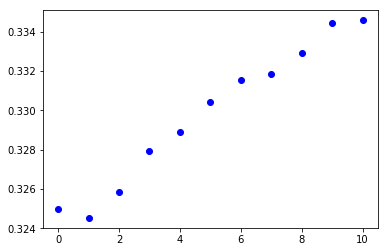

In [6]:
plt.plot(c_a1_list,"bo")
plt.show()

## Check of Power Calibration with Scope Values
Since we have an effective receiver value from the oscilloscope we can check the power calibration on the receiver by calculating what the scope should receive given $A1_{calibrated}$

$$|A_{scope}|=\frac{|A1_{calibrated} * EA_{21}|}{|1-\Gamma_{scope}*EA_{22}|}$$

In [7]:

calculated_scope_amplitudes=[]
for index,row in enumerate(scope_gamma.sparameter_complex[:]):
    frequency=row[0]
    gamma_scope=row[1]
    EA22=error_adapter.sparameter_complex[index][4]
    EA21=error_adapter.sparameter_complex[index][3]
    a1_raw=float(a1_raw_magnitude["Amplitude_A1"][index])
    c_a1=c_a1_list[index]
#     print("{0} is {1}".format("z_power_meter[index]",z_power_meter[index]))
#     print("{0} is {1}".format("gamma_pm",gamma_pm))
#     print("{0} is {1}".format("EA22",EA22))
#     print("{0} is {1}".format("EA21",EA21))
#     print("{0} is {1}".format("a1_raw",a1_raw))
#     print("{0} is {1}".format("power_meter_readings[index]",power_meter_readings[index]))
    calculated_scope_amplitude=abs(c_a1*a1_raw*EA21)/abs(1-gamma_scope*EA22)
    calculated_scope_amplitudes.append(calculated_scope_amplitude)

In [8]:
# Now we compare with the average of the scope readings
scope_amplitudes=[]
for tone in range(11):
    mean_reading=np.mean(abs(np.array(phase_calibration_summary["Scope_Amplitude"][tone*10:(tone+1)*10])))
    scope_amplitudes.append(mean_reading)

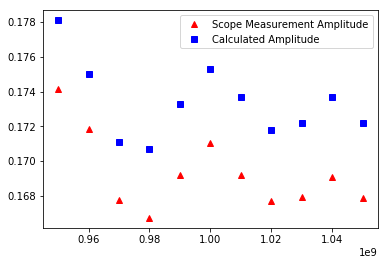

In [9]:
plt.plot(scope_gamma["Frequency"],scope_amplitudes,"r^",label="Scope Measurement Amplitude")
plt.plot(scope_gamma["Frequency"],calculated_scope_amplitudes,"bs",label="Calculated Amplitude")
plt.legend()
plt.show()

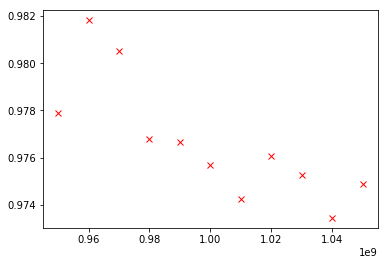

In [10]:
plt.plot(scope_gamma["Frequency"],np.array(scope_amplitudes)/np.array(calculated_scope_amplitudes),"rx",label="Scope Measurement Amplitude")
plt.show()

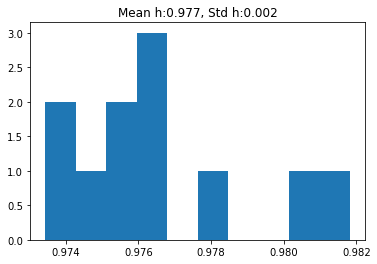

In [11]:
h_scope=np.array(scope_amplitudes)/np.array(calculated_scope_amplitudes)
plt.hist(h_scope)
plt.title("Mean h:{0:3.3f}, Std h:{1:3.3f}".format(np.mean(h_scope),np.std(h_scope)))
plt.show()
# h is supiscously close to root 2

# Phase Calibration

$$ \angle{C_{A1}} = \angle{\frac{A_{scope measured}*(1-\Gamma_{scope}EA_{22})}{|A1_{raw}|EA_{21}}}-\angle{A1_{raw}} $$
$$ A_{measured scope}=h*A_{scope}$$

In [12]:
# Required to unwrap phase and fix 90 degree phase flip from fit 
def fix_phase(phase_list):
    last_phase=phase_list[0]
    new_phase_list=[last_phase]
    for phase in phase_list[1:]:
        phase_offset=phase-last_phase
        #print("Phase Offset is {0}".format(phase_offset))
        if 90<phase_offset<270:

            new_phase=phase-180
        elif -90>phase_offset>-270:
            new_phase=phase+180
        elif -270>phase_offset:
            new_phase=phase+360
        else:
            new_phase=phase
        #print(" New Phase is {0}, Old Phase is {1}".format(new_phase,phase))
        new_phase_list.append(new_phase)
        last_phase=new_phase
    return new_phase_list

In [13]:
# Now we find the phases of the scope and correct them for gamma
scope_measured_phases=phase_calibration_summary["Scope_Phase"][:]
scope_reference_phases=[]
c_a1_phases=[]
c_awg_phases=[]
for tone in range(11):
    phase_row=[]
    calibration_phase_row=[]
    raw_row=[]
    awg_phase_row=[]
    for index,phase in enumerate(fix_phase(scope_measured_phases[tone*10:(tone+1)*10])):
        a_scope_measured=h_scope[index//10]*cmath.rect(abs(float(phase_calibration_summary["Scope_Amplitude"][index])),phase*np.pi/180.)
        gamma_scope=scope_gamma.sparameter_complex[index//10][1]
        angle_a_raw=float(fix_phase(phase_calibration_summary["Vna_Phase"])[index])
        amplitude_a_raw=float(a1_raw_magnitude["Amplitude_A1"][index//10])
        EA22=error_adapter.sparameter_complex[index//10][4]
        EA21=error_adapter.sparameter_complex[index//10][2]
        reference_phase=np.angle(a_scope_measured*(1-gamma_scope*EA22)/(amplitude_a_raw*EA21),deg=True)
        phase_row.append(reference_phase)
        raw_row.append(angle_a_raw)
        a_awg_amplitude=float(phase_calibration_summary["AWG_Set_Amplitude"][index])
        a_awg_phase=float(phase_calibration_summary["AWG_Set_Phase"][index])
        awg_phase_row.append(a_awg_phase)
        #alibration_phase=reference_phase-angle_a_raw
        #alibration_phase_row.append(calibration_phase)
#         print("{0} is {1}".format("phase",phase))
#         print("{0} is {1}".format("amplitude_a_raw",amplitude_a_raw))
#         print("{0} is {1}".format("reference_phase",reference_phase))
#         print("{0} is {1}".format("calibration_phase",calibration_phase))
    
    phase_row=np.array(fix_phase(phase_row))
    raw_row=np.array(fix_phase(raw_row))
    awg_phase_row=np.array(fix_phase(awg_phase_row))
    
    calibration_phase_row=phase_row-raw_row
    awg_calibratiton_phase_row=phase_row-awg_phase_row
    scope_reference_phases.append(np.mean(phase_row))
    c_a1_phases.append(np.mean(calibration_phase_row))
    c_awg_phases.append(np.mean(awg_calibratiton_phase_row))
c_a1_phases=fix_phase(c_a1_phases)
c_awg_phases=fix_phase(c_awg_phases)

In [14]:
phase_calibration_summary.column_names

['Tone',
 'Frequency',
 'AWG_Set_Amplitude',
 'AWG_Set_Phase',
 'Scope_Amplitude',
 'Scope_Phase',
 'Vna_Amplitude',
 'Vna_Phase',
 'Vna_Comb_Referenced_Amplitude',
 'Vna_Comb_Referenced_Phase']

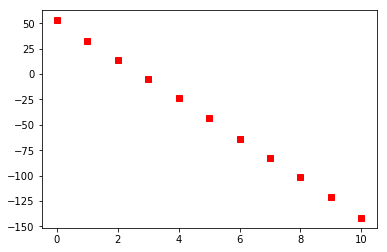

In [15]:

plt.plot(c_a1_phases,"rs")
#plt.plot(c_a1_phases,"bo")
plt.show()

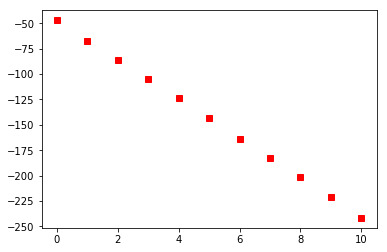

In [107]:

plt.plot(np.array(c_awg_phases),"rs")
#plt.plot(c_a1_phases,"bo")
plt.show()

In [16]:
# Now we can save the calibration coefficients as a s1p.
c_a1_complex=[]
for index,phase in enumerate(c_a1_phases[:]):
    frequency=float(a1_raw_magnitude["Frequency"][index])
    ca1=cmath.rect(c_a1_list[index],phase*np.pi/180.)
    c_a1_complex.append([frequency,ca1])
    

In [17]:
correction_coefficent=S1PV1(None,sparameter_complex=c_a1_complex)
correction_coefficent.path=os.path.join(data_directory,"C_A1.s1p")
correction_coefficent.save()

In [18]:
c_awg_complex=[]
for index,phase in enumerate(c_awg_phases[:]):
    frequency=float(a1_raw_magnitude["Frequency"][index])
    a1_raw=float(a1_raw_magnitude["Amplitude_A1"][index])
    mag_cawg=c_a1_list[index]*a1_raw/.5
    cawg=cmath.rect(mag_cawg,phase*np.pi/180.)
    c_awg_complex.append([frequency,cawg])

In [19]:
awg_correction_coefficent=S1PV1(None,sparameter_complex=c_awg_complex)
awg_correction_coefficent.path=os.path.join(data_directory,"C_AWG.s1p")
awg_correction_coefficent.save()

### Predistortion Constants

$$A_{awg}=A_{measured scope}\frac{(1-\Gamma_{scope}EA_{22})}{h*C_{awg}EA_{22}}$$
$$C_{awg-scope}=\frac{(1-\Gamma_{scope}EA_{22})}{h*C_{awg}EA_{22}}$$

In [20]:
# Now we can calculate C_awg_scope
c_awg_scope=[]
for tone in range(11):
    gamma_scope=scope_gamma.sparameter_complex[tone][1]
    EA22=error_adapter.sparameter_complex[tone][4]
    EA21=error_adapter.sparameter_complex[tone][3]
    h=h_scope[tone]
    cawg=c_awg_complex[tone][1]
    frequency=scope_gamma["Frequency"][tone]
    c=(1-gamma_scope*EA22)/(h*cawg*EA22)
    c_awg_scope.append([frequency,c])
scope_awg_correction_coefficent=S1PV1(None,sparameter_complex=c_awg_scope)
scope_awg_correction_coefficent.path=os.path.join(data_directory,"C_Awg_Scope.s1p")
scope_awg_correction_coefficent.save()
    

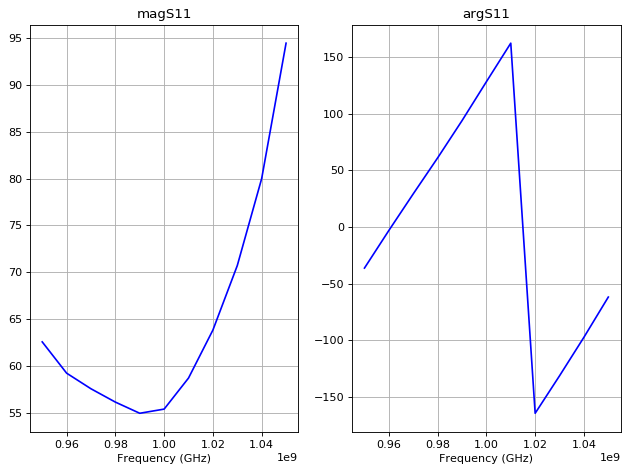

In [21]:
scope_awg_correction_coefficent.show();

In [118]:
scope_awg_correction_coefficent.change_data_format("MA")
print scope_awg_correction_coefficent

# GHz S MA R 50
9.5e+08  62.56  -36.19
9.6e+08  59.22  -3
9.7e+08  57.55  29.32
9.8e+08  56.13  61.07
9.9e+08  54.94  93.94
1e+09  55.38  128.3
1.01e+09  58.7  162.4
1.02e+09  63.83  -164.4
1.03e+09  70.72  -131.3
1.04e+09  80.01  -97.29
1.05e+09  94.48  -61.79


$A_{awg}=A_{measured scope}C_{awg-scope}$

$C_{awg-scope}=\frac{(1-\Gamma_{scope}EA_{22})}{h*C_{awg}EA_{22}}$

In [4]:
in_file=open(r"C:\Share\AWG_Phase_Calibration\Schroeder_Phase_20181022\Phase_Calibration_Measurement\11_Tones_10000KHz_Spacing\Tone_0_Phase_108_Calibration.bin","rb")
data=in_file.read()

In [10]:
options={"data_delimiter": "\t", "column_name_begin_line":0,"data_begin_line":1,"column_types":["float" for i in range(5)]}
scope_location=r"C:\Share\AWG_Phase_Calibration\Schroeder_Phase_20181022\Phase_Calibration_Measurement\11_Tones_10000KHz_Spacing\Tone_0_Phase_000_Calibration_Scope_Measurement.txt"
scope_data=AsciiDataTable(scope_location,**options)

In [9]:
scope_data.column_names

['Time', 'CHAN1', 'CHAN2', 'CHAN3', 'CHAN4']

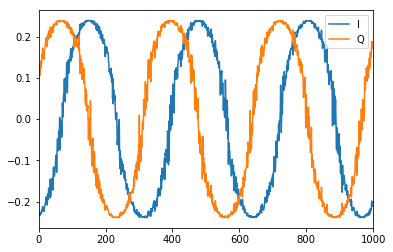

In [16]:
plt.plot(scope_data["CHAN3"],label="I")
plt.plot(scope_data["CHAN4"],label="Q")
plt.xlim([0,1000])
plt.legend()
plt.show()

In [18]:
from pyMez.Code.Analysis.Fitting import *

Phase I in degrees 58.6982398775
Phase Q in degrees -29.5691417434


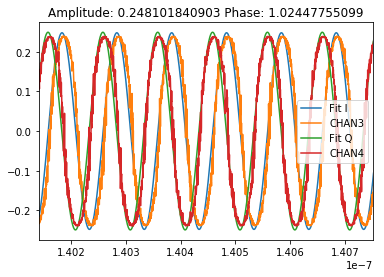

In [27]:
frequency=10*10**9
fit_cosine=FunctionalModel(variables=["t"],parameters=["A","phi"],equation="A*cos(2*pi*t*{0}+phi)".format(frequency))
x_data=10**-9*np.array(map(lambda x:float(x),scope_data["Time"]))
I_data=np.array(map(lambda x:float(x),scope_data["CHAN3"]))
fit_cosine.fit_data(x_data=x_data,y_data=I_data)
plt.close()
plt.plot(x_data,fit_cosine(x_data),label="Fit I")
plt.plot(x_data,I_data,label="CHAN3")
fit_parameters=fit_cosine.parameter_values
plt.title("Amplitude: {A} Phase: {phi}".format(**fit_parameters))
print("Phase I in degrees {0}".format(fit_parameters["phi"]*180/np.pi))
x_data=10**-9*np.array(map(lambda x:float(x),scope_data["Time"]))
Q_data=np.array(map(lambda x:float(x),scope_data["CHAN4"]))
fit_cosine.fit_data(x_data=x_data,y_data=Q_data)
plt.plot(x_data,fit_cosine(x_data),label="Fit Q")
plt.plot(x_data,Q_data,label="CHAN4")
print("Phase Q in degrees {0}".format(fit_cosine.parameter_values["phi"]*180/np.pi))

plt.legend()
plt.xlim([x_data[0],x_data[2000]])
plt.show()

In [28]:
# get all of the I and Q measurements
data_directory=r"C:\Share\AWG_Phase_Calibration\Schroeder_Phase_20181022\Phase_Calibration_Measurement\11_Tones_10000KHz_Spacing"
all_file_names=os.listdir(data_directory)
scope_file_names=[]
for file_name in all_file_names:
    if re.search("Calibration_Scope_Measurement",file_name):
        scope_file_names.append(file_name)


In [30]:
scope_data_files=list(map(lambda x:AsciiDataTable(os.path.join(data_directory,x),**options),scope_file_names))

In [32]:
frequency=10*10**9
fit_data=[]
for scope_data_file in scope_data_files:
    fit_cosine=FunctionalModel(variables=["t"],parameters=["A","phi"],equation="A*cos(2*pi*t*{0}+phi)".format(frequency))
    x_data=10**-9*np.array(map(lambda x:float(x),scope_data_file["Time"]))
    I_data=np.array(map(lambda x:float(x),scope_data_file["CHAN3"]))
    Q_data=np.array(map(lambda x:float(x),scope_data_file["CHAN4"]))
    data_row={}
    fit_cosine.fit_data(x_data=x_data,y_data=I_data)
    data_row["I_Amplitude"]=fit_cosine.parameter_values["A"]
    data_row["I_Phase"]=fit_cosine.parameter_values["phi"]*180/np.pi
    fit_cosine.fit_data(x_data=x_data,y_data=Q_data)
    data_row["Q_Amplitude"]=fit_cosine.parameter_values["A"]
    data_row["Q_Phase"]=fit_cosine.parameter_values["phi"]*180/np.pi
    fit_data.append(data_row)

In [36]:
fit_table=AsciiDataTable(None,data_list_dictionary=fit_data,column_types=["float" for i in range(4)])

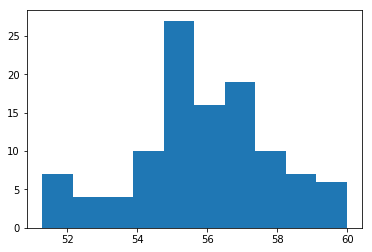

In [57]:
plt.hist(fit_table["I_Phase"])
plt.show()

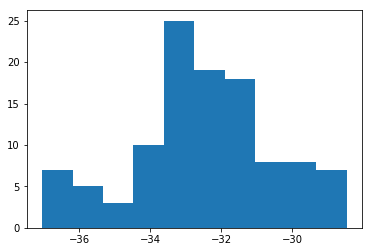

In [58]:
plt.hist(fit_table["Q_Phase"])
plt.show()

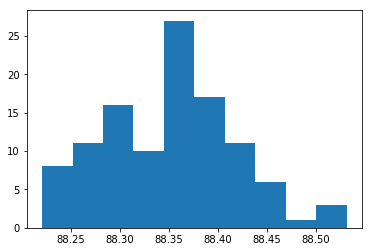

In [59]:
plt.hist(np.array(fit_table["I_Phase"])-np.array(fit_table["Q_Phase"]))
plt.show()

In [42]:
print("I Mean: {0}".format(np.mean(fit_table["I_Phase"])))
print("I Std: {0}".format(np.std(fit_table["I_Phase"])))
print("Q Mean: {0}".format(np.mean(fit_table["Q_Phase"])))
print("Q Std: {0}".format(np.std(fit_table["Q_Phase"])))

I Mean: 58.5074828088
I Std: 1.4530439191
Q Mean: -29.829883678
Q Std: 1.45474472842


In [47]:
# get all of the I and Q measurements
top_directory=r"C:\Share\AWG_Phase_Calibration\Schroeder_Phase_20181022\Phase_Calibration_Measurement"
data_directory_list=os.listdir(top_directory)
data_directory_list=list(map(lambda x:os.path.join(top_directory,x),data_directory_list))
IQ_summary_data=[]
for data_directory in data_directory_list:
    #data_directory=r"C:\Share\AWG_Phase_Calibration\Schroeder_Phase_20181022\Phase_Calibration_Measurement\11_Tones_10000KHz_Spacing"
    all_file_names=os.listdir(data_directory)
    scope_file_names=[]
    for file_name in all_file_names:
        if re.search("Calibration_Scope_Measurement",file_name):
            scope_file_names.append(file_name)
    scope_data_files=list(map(lambda x:AsciiDataTable(os.path.join(data_directory,x),**options),scope_file_names))
    frequency=10*10**9
    fit_data=[]
    for scope_data_file in scope_data_files:
        fit_cosine=FunctionalModel(variables=["t"],parameters=["A","phi"],equation="A*cos(2*pi*t*{0}+phi)".format(frequency))
        x_data=10**-9*np.array(map(lambda x:float(x),scope_data_file["Time"]))
        I_data=np.array(map(lambda x:float(x),scope_data_file["CHAN3"]))
        Q_data=np.array(map(lambda x:float(x),scope_data_file["CHAN4"]))
        data_row={}
        fit_cosine.fit_data(x_data=x_data,y_data=I_data)
        data_row["I_Amplitude"]=fit_cosine.parameter_values["A"]
        data_row["I_Phase"]=fit_cosine.parameter_values["phi"]*180/np.pi
        fit_cosine.fit_data(x_data=x_data,y_data=Q_data)
        data_row["Q_Amplitude"]=fit_cosine.parameter_values["A"]
        data_row["Q_Phase"]=fit_cosine.parameter_values["phi"]*180/np.pi
        fit_data.append(data_row)
    fit_table_options={"data_list_dictionary":fit_data,"column_types":["float" for i in range(4)],
                      "directory":data_directory,"specific_descriptor":"IQ_Fit","general_descriptor":"Scope_Data"}
    fit_table=AsciiDataTable(None,**fit_table_options)
    fit_table.options["metadata"]={}
    fit_table.options["metadata"]["I_phase_mean"]=np.mean(fit_table["I_Phase"])
    fit_table.options["metadata"]["I_phase_std"]=np.std(fit_table["I_Phase"])
    fit_table.options["metadata"]["Q_phase_mean"]=np.mean(fit_table["Q_Phase"])
    fit_table.options["metadata"]["Q_phase_std"]=np.std(fit_table["Q_Phase"])
    fit_table.options["metadata"]["data_directory"]=data_directory
    IQ_summary_data.append(fit_table.options["metadata"])
    fit_table.save()

In [45]:
fit_table.path

'C:\\Share\\AWG_Phase_Calibration\\Schroeder_Phase_20181022\\Phase_Calibration_Measurement\\11_Tones_10000KHz_Spacing\\Data_Scope_Data_20181108_001.txt'

In [46]:
fit_table.options["metadata"]

{'I_phase_mean': 58.507482808829891,
 'I_phase_std': 1.4530439190983462,
 'Q_phase_mean': -29.829883678035582,
 'Q_phase_std': 1.4547447284227213}

In [48]:
IQ_summary_data

[{'I_phase_mean': 58.507482808829891,
  'I_phase_std': 1.4530439190983462,
  'Q_phase_mean': -29.829883678035582,
  'Q_phase_std': 1.4547447284227213,
  'data_directory': 'C:\\Share\\AWG_Phase_Calibration\\Schroeder_Phase_20181022\\Phase_Calibration_Measurement\\11_Tones_10000KHz_Spacing'},
 {'I_phase_mean': 57.197412771327699,
  'I_phase_std': 1.2187681366583187,
  'Q_phase_mean': -31.132434693472046,
  'Q_phase_std': 1.226420589540584,
  'data_directory': 'C:\\Share\\AWG_Phase_Calibration\\Schroeder_Phase_20181022\\Phase_Calibration_Measurement\\11_Tones_2500KHz_Spacing'},
 {'I_phase_mean': 60.726221292572383,
  'I_phase_std': 1.1978036218924641,
  'Q_phase_mean': -27.601503494959381,
  'Q_phase_std': 1.1912955987633158,
  'data_directory': 'C:\\Share\\AWG_Phase_Calibration\\Schroeder_Phase_20181022\\Phase_Calibration_Measurement\\11_Tones_250KHz_Spacing'},
 {'I_phase_mean': 53.075792165270336,
  'I_phase_std': 1.9329180639163501,
  'Q_phase_mean': -35.216249293114245,
  'Q_phase_std

In [49]:
IQ_summary_data_table=AsciiDataTable(None,data_list_dictionary=IQ_summary_data)

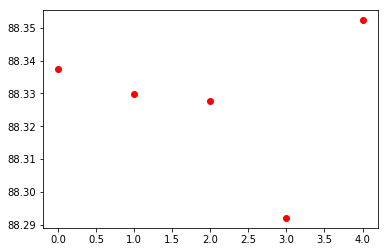

In [56]:
I_mean_array=np.array(map(lambda x:float(x),IQ_summary_data_table["I_phase_mean"]))
Q_mean_array=np.array(map(lambda x:float(x),IQ_summary_data_table["Q_phase_mean"]))
plt.plot(I_mean_array-Q_mean_array,"ro")
plt.show()

In [53]:
IQ_summary_data_table.path=r"C:\Share\AWG_Phase_Calibration\Schroeder_Phase_20181022\Analysis\IQ_Fit_Summary.txt"

In [54]:
IQ_summary_data_table.save()

In [ ]:
data_directory=r"C:\Share\AWG_Phase_Calibration\Schroeder_Phase_20181022\Phase_Calibration_Measurement\11_Tones_10000KHz_Spacing"
all_file_names=os.listdir(data_directory)
scope_file_names=[]
for file_name in all_file_names:
    if re.search("Calibration_Scope_Measurement",file_name):
        scope_file_names.append(file_name)